In [1]:
import torch
import torch.nn as nn
import pickle
import numpy as np
from utils import datasets, model_utils, metrics
from collections import defaultdict, OrderedDict

from sklearn.linear_model import Lasso
import xgboost as xgb
from sklearn.metrics import roc_auc_score, average_precision_score

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_model(path, train_dataset, test_dataset):
    checkpoint = torch.load(path)
    state_dict = checkpoint["checkpoint"]
    args = checkpoint["args"]

    print(args['block_type'])
    print(args['input_block'])
    print(args['output_block'])    
    print(args)
    
    model = model_utils.get_model(args, train_dataset, test_dataset)
    model.load_state_dict(state_dict)    
    return model

def get_logits(model, inputs):
    out = model.extractor(inputs).transpose(1, 2)
    out, _ = model.model.rnn(model.model.input_layer(out))
    #out = model.model.output_layer(out)    
    return out

def get_model_logits(model, dataloader, device='cuda'):
    outputs = []
    labels = []
    model.to(device)
    for inputs, labels_ in dataloader:
        out = get_logits(model, inputs.to(device))
        outputs.append(out)
        labels.append(labels_)
    outputs = torch.cat(outputs).detach().cpu().numpy()
    labels = torch.cat(labels).detach().cpu().numpy()
    return outputs, labels

In [3]:
experiments_name = 'explosion'
train_dataset, test_dataset = datasets.CPDDatasets(experiments_name=experiments_name).get_dataset_()

Equal sampling is impossible, do random sampling.


In [4]:
linear_path = 'saves/models/best_explosion/model_x3d_m_bce_tl_221217T161508.pth'
linear_path_2 = 'saves/models/explosion/model_x3d_m_bce_tl_230412T153056.pth'
tcl_path = 'saves/models/best_explosion/model_x3d_m_bce_tl_230120T145822.pth'
tcl_path2 = 'saves/models/explosion/model_x3d_m_bce_tl_230412T110346.pth'

In [ ]:
linear_model = load_model(linear_path, train_dataset, test_dataset)
linear_outputs = {}
train = get_model_logits(linear_model, linear_model.train_dataloader())
test = get_model_logits(linear_model, linear_model.val_dataloader())

linear_outputs["train_outputs"] = train[0]
linear_outputs["train_target"] = train[1]
linear_outputs["test_outputs"] = test[0]
linear_outputs["test_target"] = test[1]

with open('linear_outputs.pickle', 'wb') as f:
    pickle.dump(linear_outputs, f)

In [5]:
with open('tcl_outputs.pickle', 'rb') as f:
    tcl_outputs_big = pickle.load(f)
    
with open('tcl_outputs_2.pickle', 'rb') as f:
    tcl_outputs_small = pickle.load(f)   
    
with open('linear_outputs.pickle', 'rb') as f:
    linear_outputs_small = pickle.load(f)     
    
with open('linear_outputs_2.pickle', 'rb') as f:
    linear_outputs_big = pickle.load(f)            

In [6]:
def prepare_data(dict_outputs, model_type='linear'):

    train_data = dict_outputs['train_outputs']
    test_data = dict_outputs['test_outputs']
    
    y_train = dict_outputs['train_target'].flatten()
    y_test = dict_outputs['test_target'].flatten()    

    if model_type == 'tcl':
        train_data = np.reshape(train_data, (*(train_data.shape[:2]), -1))    
        test_data = np.reshape(test_data, (*(test_data.shape[:2]), -1))
        
    X_train = train_data.reshape(-1, train_data.shape[-1])
    X_test = test_data.reshape(-1, test_data.shape[-1])
    
    return (X_train, y_train), (X_test, y_test) 

In [7]:
def train_test_lasso(outputs, alpha, model_type='linear'):
    (X_train, y_train), (X_test, y_test) = prepare_data(outputs, model_type)
    
    linear = Lasso(alpha=alpha)
    linear.fit(X_train, y_train)
    pred_linear = linear.predict(X_test)
    return linear.coef_, roc_auc_score(y_test, pred_linear), average_precision_score(y_test, pred_linear)    
    

def run_lasso_experiment(outputs, model_type='linear'):
    
    big_alphas  = [0, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
    
    lasso_coefs = {}
    roc_aucs = {}
    pr_aucs = {}
    
    for i, alpha in enumerate(big_alphas):    
        res = train_test_lasso(outputs, alpha, model_type=model_type)
        lasso_coefs[alpha], roc_aucs[alpha], pr_aucs[alpha] = res
        if sum(res[0] != 0) <= 64:
            start = 0 if alpha == 0 else big_alphas[i - 1]
            for i, alpha in enumerate(np.linspace(start, 1, 10000)): 
                res = train_test_lasso(outputs, alpha, model_type=model_type)
                lasso_coefs[alpha], roc_aucs[alpha], pr_aucs[alpha] = res
            break
    return lasso_coefs, roc_aucs, pr_aucs

In [8]:
res_tcl_small = run_lasso_experiment(tcl_outputs_small, model_type='tcl')
res_tcl_big = run_lasso_experiment(tcl_outputs_big, model_type='tcl')
res_linear_big = run_lasso_experiment(linear_outputs_big, model_type='linear')
res_linear_small = run_lasso_experiment(linear_outputs_small, model_type='linear')

In [9]:
def process_result(result):
    lasso_coefs, roc_aucs, pr_aucs = result
    features_rocauc = defaultdict(float)
    features_prauc = defaultdict(float)
    
    for alpha in lasso_coefs.keys():
        features = sum(lasso_coefs[alpha] != 0)
        if features == 0 or features > 64:
            continue
        features_rocauc[features] = max(features_rocauc[features], roc_aucs[alpha].round(3))
        features_prauc[features] = max(features_prauc[features], pr_aucs[alpha].round(3))
    features_rocauc = OrderedDict(sorted(features_rocauc.items(), key=lambda t: t[0]))
    features_prauc = OrderedDict(sorted(features_prauc.items(), key=lambda t: t[0]))
    return features_rocauc, features_prauc

In [10]:
lin_big_roc, lin_big_pr = process_result(res_linear_big)
lin_small_roc, lin_small_pr = process_result(res_linear_small)
tcl_big_roc, tcl_big_pr = process_result(res_tcl_small)
tcl_small_roc, tcl_small_pr = process_result(res_tcl_big)

In [42]:
lin_big_roc[64] = 0.705
lin_small_roc[64] = 0.761
tcl_small_roc[64] = 0.862

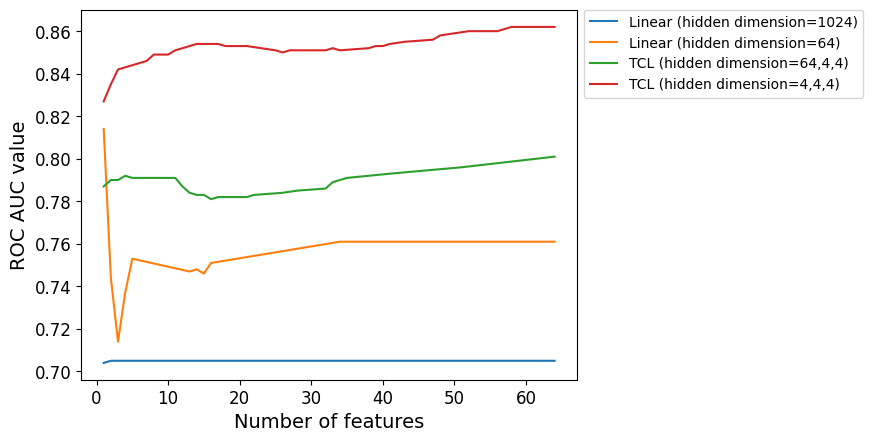

In [83]:
plt.plot(lin_big_roc.keys(), lin_big_roc.values(), label='Linear (hidden dimension=1024)')
plt.plot(lin_small_roc.keys(), lin_small_roc.values(), label='Linear (hidden dimension=64)')
plt.plot(tcl_big_roc.keys(), tcl_big_roc.values(), label='TCL (hidden dimension=64,4,4)')
plt.plot(tcl_small_roc.keys(), tcl_small_roc.values(), label='TCL (hidden dimension=4,4,4)')
#plt.legend(bbox_to_anchor=(0.35, -0.05))
plt.legend(bbox_to_anchor=(1.0, 1.02))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Number of features', fontsize=14)
plt.ylabel('ROC AUC value', fontsize=14)
plt.savefig('lasso_exp_rocauc.png', dpi=500, bbox_inches='tight')

In [78]:
lin_big_pr[64] = 0.038
lin_small_pr[64] = 0.145
tcl_small_pr[64] = 0.264

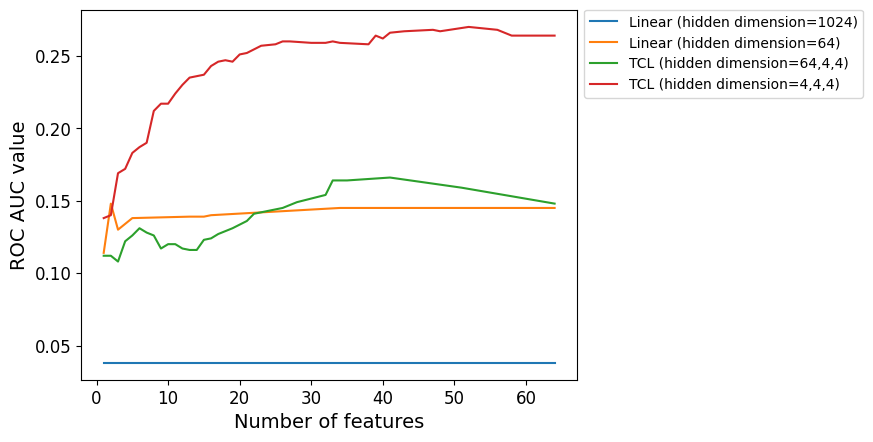

In [82]:
plt.plot(lin_big_pr.keys(), lin_big_pr.values(), label='Linear (hidden dimension=1024)')
plt.plot(lin_small_pr.keys(), lin_small_pr.values(), label='Linear (hidden dimension=64)')
plt.plot(tcl_big_pr.keys(), tcl_big_pr.values(), label='TCL (hidden dimension=64,4,4)')
plt.plot(tcl_small_pr.keys(), tcl_small_pr.values(), label='TCL (hidden dimension=4,4,4)')
#plt.legend(bbox_to_anchor=(0.35, -0.05))
plt.legend(bbox_to_anchor=(1.0, 1.02))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Number of features', fontsize=14)
plt.ylabel('ROC AUC value', fontsize=14)
plt.savefig('lasso_exp_prauc.png', dpi=500, bbox_inches='tight')